# Lab 3- Training the Deep Neural Network in your head (aka Hand Scan)

DUE: 10 am, 2/10/2017. A snapshot will be taken at this time. We will discuss these problems throughout the following week.

## Introduction
Before High Energy Physicists used computers with automatic reconstruction to turn raw data into features, they relied on hand scans performed by people. In this lab we will setup a hand scan using the Liquid Argon TPC (LArTPC) data we looked at last time. The task will be to identify the type of particle. You will be the handscanner. The steps are as follows:

    * Data Engineering: Load data from various files
    * Training: Train the handscanner by presenting images of the data with the labels.
    * Validation: Ask the handscanner to classify some randomly selected images, and see how well they do.


## Data Engineering

Our data is stored in a bunch of files. You can see the files by listing the directory using the unix "ls" command. You can call shell commands, like "ls", from Jupyter:

In [8]:
!ls /data/LArIAT/h5_files/

antielectron_0-1462146945.h5   nue_NC_2-1469424927.h5
antielectron_0-1462204074.h5   nue_NC_3-1469424406.h5
antielectron_0-1462522993.h5   nue_NC_3-1469424430.h5
antielectron_10-1462146945.h5  nue_NC_3-1469424486.h5
antielectron_10-1462204074.h5  nue_NC_3-1469424508.h5
antielectron_10-1462522993.h5  nue_NC_3-1469424546.h5
antielectron_11-1462146945.h5  nue_NC_3-1469424625.h5
antielectron_11-1462204074.h5  nue_NC_3-1469424649.h5
antielectron_11-1462522993.h5  nue_NC_3-1469424674.h5
antielectron_1-1462146945.h5   nue_NC_3-1469424696.h5
antielectron_1-1462204074.h5   nue_NC_3-1469424718.h5
antielectron_1-1462522993.h5   nue_NC_3-1469424737.h5
antielectron_12-1462204074.h5  nue_NC_3-1469424783.h5
antielectron_12-1462522993.h5  nue_NC_3-1469424815.h5
antielectron_13-1462204074.h5  nue_NC_3-1469424840.h5
antielectron_13-1462522993.h5  nue_NC_3-1469424856.h5
antielectron_14-1462146945.h5  nue_NC_3-1469424901.h5
antielectron_14-1462204074.h5  nue_NC_3-1469424927.h5
antielectron_14-1462522993.h

That's a lot of files. Lets count how many... in python. There are a variety of ways of getting back a directory listing in python. Here's one:

In [2]:
import glob
Files=glob.glob("/data/LArIAT/h5_files/*")
print "Number of Files:", len(Files)
print "First Filename:", Files[0]

Number of Files: 6745
First Filename: /data/LArIAT/h5_files/electron_9-1463722329.h5


Looking at the file names, you notice that they start with the type of particle. Each file contains a samples of "events". In each event, we simulated shooting a particle into the detector and stored the response. The name of the file specifies what type of particle was simulated in that file.

Let's try to figure out what types. We'll loop over the file names, strip out the first part of the file name, and store it in a dictionary:

In [3]:
import os

FileCount= {}  # Store the count here
FileLists= {}  # Organize the files by particle type here.

for aFile in Files:
    # Lets strip the path (everything before the "/"s) and get the filename:
    FileName=os.path.basename(aFile)
    
    # Now use everything before the first "_" as the particle name
    ParticleName=FileName.split('_')[0]
    
    if ParticleName in FileCount.keys():
        FileCount[ParticleName]+=1
        FileLists[ParticleName].append(aFile)
    else:
        FileCount[ParticleName]=1
        FileLists[ParticleName]= [aFile]
    
print "Number of types of particles:", len(FileCount.keys())
print "----------------------------------------------------------"
print "Number of files for each particle type:", FileCount
print "----------------------------------------------------------"
print "First file of each type:"
for aFile in FileLists:
    print aFile,":",FileLists[aFile][0]

Number of types of particles: 16
----------------------------------------------------------
Number of files for each particle type: {'numu': 944, 'kaonPlus': 417, 'antielectron': 48, 'pion': 240, 'numubar': 747, 'nuebar': 631, 'photon': 185, 'antiproton': 360, 'proton': 268, 'electron': 339, 'muon': 277, 'pionPlus': 399, 'kaonMinus': 396, 'nue': 616, 'antimuon': 411, 'pionMinus': 467}
----------------------------------------------------------
First file of each type:
numu : /data/LArIAT/h5_files/numu_CC_7-1468443731.h5
kaonPlus : /data/LArIAT/h5_files/kaonPlus_11-1466643524.h5
antielectron : /data/LArIAT/h5_files/antielectron_17-1462522993.h5
pion : /data/LArIAT/h5_files/pion_0_19-1463161413.h5
numubar : /data/LArIAT/h5_files/numubar_CC_1-1469306203.h5
nuebar : /data/LArIAT/h5_files/nuebar_CC_3-1469468394.h5
photon : /data/LArIAT/h5_files/photon_12-1466805843.h5
antiproton : /data/LArIAT/h5_files/antiproton_7-1466998603.h5
proton : /data/LArIAT/h5_files/proton_8-1466779796.h5
electron 

We can count how many examples are in each file by open them up in h5py like we did in the last lab:

In [4]:
import h5py

f=h5py.File(FileLists["pionPlus"][0],"r")

# Read the First N_Events. Data is stored as float16, lets store it as float32 to avoid overflows later when we sum.
print "Shape of the data:", f["features"].shape
print "Number of events in file:", f["features"].shape[0]

f.close()

Shape of the data: (500, 2, 240, 4096)
Number of events in file: 500


### Exercise 3.1- Basic File Manipulation

Create two dictionaries. Store the total number of events of each particle type in one. Store the number events in each file in another. 

In [5]:
N_Events_perType = {} #key is particle type
N_Events_perFile = {} #key is file

### BEGIN SOLUTION

for FileType in FileLists.keys():
    for i in range (len(FileType)):
        f=h5py.File(FileLists[FileType][i], "r")
        count=f["features"].shape[0]

        N_Events_perFile[FileLists[FileType][i]]=count

        if FileType in N_Events_perType.keys():
            N_Events_perType[FileType]+=count
        else:
            N_Events_perType[FileType]=count   
            
#for k in N_Events_perType:
#    print("Events in type " + k, N_Events_perType[k])
#for k in N_Events_perFile:
#    print("Events in file " + k, N_Events_perFile[k])
    
### END SOLUTION

## Training

We will use matplotlib for most of our plotting. There are lots of tutorials and primers out there that you can find searching the web. A good tutorial can be found in the [Scipy Lectures](http://www.scipy-lectures.org/intro/matplotlib/matplotlib.html). Look through these on your own time, it is not necessary for doing these exercise.

The raw data from a LArTPC detector looks like an image. The LArIAT detector, which we have simulated, has 2 readout views. The following code gives you an example how to plot these images. 

Data shape: (500, 2, 240, 4096)


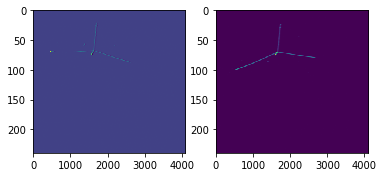

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load the first pion file
f=h5py.File(FileLists["pionPlus"][0],"r")

# Get the images
images=f["features"]

print "Data shape:", images.shape

def PlotEvent(image):
    # Make two plots. Create a 1 by 2 grid the plots.
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)

    # Plot the first view. Note: [EventNumber, View] = [0,0]
    ax1.imshow(np.array(image[0],dtype="float32"))

    # Plot the second view 
    ax2.imshow(np.array(image[1],dtype="float32"))

    # The data is 240 by 4096. Change the aspect ratio so the plot is not squished. 
    ax1.set_aspect(16)  
    ax2.set_aspect(16) 

# Plot the 5th Event
PlotEvent(images[4])

f.close()

### Exercise 3.2.1- Setup Training

Write a function that takes a file, and creates a grid of plots showing the first N events. Use this function to plot the first 9 events in the first file of each particle type in a 3 by 3 grid. You only need to show one view.

numu :
kaonPlus :
antielectron :
pion :
numubar :
nuebar :
photon :
antiproton :
proton :
electron :
muon :
pionPlus :
kaonMinus :
nue :
antimuon :
pionMinus :


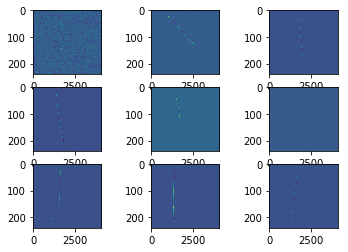

In [23]:
def PlotEvents(FileName, N_Events):
    ### BEGIN SOLUTION

    #f=h5py.File(FileLists["pionPlus"][0],"r") - already covered by FileName
    f=h5py.File(FileName, "r")
    images=f["features"]
    
    #for each one particle, go through, grab the first N events, and plot them in a 3x3 grid
    #and then move on to the next particle
    
    plots=[]
    
    for i in range (N_Events): #draw N_Events plots for each one file run through PlotEvents
        image=images[i]
        ax=plt.subplot(3,3,(i+1)) #plot numbering starts at 1, not 0
        ax.imshow(np.array(image[0],dtype="float32"))
        ax.set_aspect(16)
        plots.append(ax)
        #why is it that only the last 9 plots are shown?
        #this still happens even if I put in a pause between each step of the loop
        #note to self: work on this more, unless i forget
        
    #print(len(plots))
    #for box in plots:
    #    box.plot()
    
    ### END SOLUTION
    f.close()
    pass

for aFile in FileLists: #this goes through all of the file types
    FileName=FileLists[aFile][0]
    ParticleName=os.path.basename(FileName).split('_')[0]
    
    print ParticleName,":"
    if(ParticleName=="antimuon"):
        N_Events=2
    else: N_Events=9
    PlotEvents(FileName,N_Events) #so it already goes through every particle
    #answer=str(raw_input('Continue?: ')) #ask for it to check, to step through each one

### Exercise 3.2.2- Train Yourself

By looking closely at each particle type, identify at least one "feature" that would allow you to by eye uniquely identify that particle type. 

Type you answer in this box.

### BEGIN SOLUTION

- muon/antimuon: your description here
- electron/antielectron: your description here
- pion: your description here
- pionPlus/pionMinus: your description here
- kaonPlus/kaonMinus: your description here
- photon: your description here
- nue/nuebar: your description here
- numu/numubar: your description here
- proton/antiproton: your description here

### END SOLUTION

## Validation (Homework)

Now we have to setup a validation process. We will first assign each particle type a unique index. Then we will load some events of each particle type, mix them while keeping track of the indecies. Finally we will present the images to the handscanner, ask them to classify, and keep track of how well they do.

Read through and try to understand the following code which setups up 2 dictionaries we will use to uniquely identify particle types. 

In [51]:
import numpy as np

# Assign index to particle type
ParticleTypesIndexMap = {}

for i,ParticleType in enumerate(FileLists.keys()):    
    ParticleTypesIndexMap[ParticleType]=i
    
# Merge particle/anti-particle
for ParticleName in ParticleTypesIndexMap:
    if 'bar' in ParticleName:
        ParticleTypesIndexMap[ParticleName]=ParticleTypesIndexMap[ParticleName.split('bar')[0]]
        
    if 'anti' in ParticleName:
        ParticleTypesIndexMap[ParticleName]=ParticleTypesIndexMap[ParticleName.split('anti')[1]]

    if 'Minus' in ParticleName:
        ParticleTypesIndexMap[ParticleName]=ParticleTypesIndexMap[ParticleName.split('Minus')[0]+"Plus"]
    
print "Index map:"
print ParticleTypesIndexMap

# Reverse Map
ParticleTypesIndexMapR={}

for p in ParticleTypesIndexMap:
    if ParticleTypesIndexMap[p] not in ParticleTypesIndexMapR:
        ParticleTypesIndexMapR[ParticleTypesIndexMap[p]]=p

print "Reverse Index map:"
print ParticleTypesIndexMapR



Index map:
{'numu': 0, 'nue': 13, 'antielectron': 9, 'pion': 3, 'numubar': 0, 'nuebar': 13, 'photon': 6, 'electron': 9, 'proton': 8, 'antiproton': 8, 'muon': 10, 'pionPlus': 11, 'kaonMinus': 1, 'kaonPlus': 1, 'antimuon': 10, 'pionMinus': 11}
Reverse Index map:
{0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}


Now we load the data and mix them:

In [52]:
Data_X = None
Data_Y = None
N_Events_perType=10

for ParticleType in FileLists:
    # Open the first file
    FileName=FileLists[ParticleType][1] # we will take the 2nd file so we don't use the training sample for validation
    print "Opening:",FileName
    f=h5py.File(FileName,"r")
    
    # Get the images/features
    images=np.array(f["features"][:N_Events_perType])
    
    # Warn if not enough events
    N_Events_read=images.shape[0]
    if not N_Events_read==N_Events_perType:
        print "Warning: Sample", FileName, "had only",N_Events_read,"events."
    
    # Assign labels
    labels=np.empty(N_Events_read)
    labels.fill(ParticleTypesIndexMap[ParticleType])

    # Store some of them
    try:
        # If we have already read some data, add to it
        Data_X=np.concatenate((Data_X,images))
        Data_Y=np.concatenate((Data_Y,labels))
    except:
        # If we haven't read any data yet
        Data_X=images
        Data_Y=labels
    
        
    f.close()

print Data_X.shape, Data_Y.shape

def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
    
Data_X,Data_Y=shuffle_in_unison_inplace(Data_X,Data_Y)    


Opening: /data/LArIAT/h5_files/numu_CC_7-1469162877.h5
Opening: /data/LArIAT/h5_files/kaonPlus_5-1466605529.h5
Opening: /data/LArIAT/h5_files/antielectron_2-1462204074.h5
Opening: /data/LArIAT/h5_files/pion_0_19-1465222696.h5
Opening: /data/LArIAT/h5_files/numubar_CC_10-1469306203.h5
Opening: /data/LArIAT/h5_files/nuebar_NC_0-1469513434.h5
Opening: /data/LArIAT/h5_files/photon_2-1466642559.h5
Opening: /data/LArIAT/h5_files/antiproton_7-1466998552.h5
Opening: /data/LArIAT/h5_files/proton_15-1466439654.h5
Opening: /data/LArIAT/h5_files/electron_19-1464793391.h5
Opening: /data/LArIAT/h5_files/muon_14-1466218429.h5
Opening: /data/LArIAT/h5_files/pionPlus_1-1463590721.h5
Opening: /data/LArIAT/h5_files/kaonMinus_14-1463590719.h5
Opening: /data/LArIAT/h5_files/nue_NC_14-1461971806.h5
Opening: /data/LArIAT/h5_files/antimuon_3-1466967198.h5
Opening: /data/LArIAT/h5_files/pionMinus_5-1466714027.h5
(155, 2, 240, 4096) (155,)


##  Exercise 3.3.1

The following code presents images and asks the handscanner for a type. Read through it carefully. Try it out. Then instrument this code so it keeps track of success and failures. The goal is to create a confusion matrix, a table that keeps track of how often each particle type is correctly identified and how often it is misidentified as any other type.  

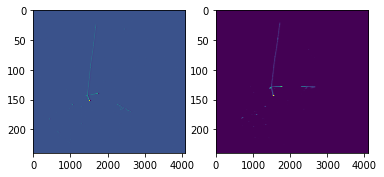

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}


In [ ]:
View=0

for image in Data_X:
    PlotEvent(image)
    plt.show()
    
    print "Select Type from:", ParticleTypesIndexMapR
    try:
        answer=int(raw_input('Input:'))
    except ValueError:
        print "Not a number"
        
    # Stop loop
    if answer==-1:
        break
    
    print "You selected:", ParticleTypesIndexMapR[answer]
        

##  Exercise 3.3.2

Make yourself the handscanner. Use above code to go through the full data sample and create a confusion matrix.

## Honors Problems:

### Exercise 3.4.1
Write a function that downsamples all of images by summing samples to reduce the 4096 long dimension of the data.

### Exercise 3.4.2
Write a function that returns a sub-region in the 4096 long dimention where the total charge is max.